# PVSystem

El sistema FV representa un inversor y los módulos FV que suministran corriente continua al inversor. Un sistema FV puede ser de montaje fijo o de seguimiento de un eje. El PVSystem está soportado por el Array que representa los módulos FV en el PVSystem. Una instancia de PVSystem tiene un único inversor, pero puede tener múltiples instancias de Array. Una instancia de la clase Array representa un grupo de módulos con la misma orientación y tipo de módulo. Diferentes instancias de Array pueden tener diferente inclinación, orientación y número o tipo de módulos, donde la orientación está definida por el montaje del Array (un FixedMount, SingleAxisTrackerMount, u otro).

Los métodos de la clase PVSystem envuelven muchas de las funciones del módulo pvsystem. Del mismo modo, las clases Mount y Array envuelven varias funciones con sus métodos de clase. Los métodos que envuelven funciones tienen nombres similares a los de las funciones envueltas. Esta práctica simplifica la API de los métodos PVSystem y Array al eliminar la necesidad de especificar argumentos que se almacenan como atributos de estas clases, como las propiedades del módulo y del inversor. Utilizar PVSystem no es ni mejor ni peor que utilizar las funciones que envuelve - es una forma alternativa de organizar sus datos y cálculos.

El objetivo de esta guía es facilitar la comprensión de la clase PVSystem. Asume una familiaridad básica con el código orientado a objetos en Python, pero la mayor parte de la información debería ser comprensible sin una sólida comprensión de las clases. Tenga en cuenta que las funciones son independientes de los objetos, mientras que los métodos se adjuntan a los objetos.

Véase ModelChain para una aplicación de PVSystem al modelado de series temporales.

Filosofía de diseño

La clase PVSystem permite a los modelizadores separar fácilmente los datos que representan un sistema fotovoltaico (por ejemplo, el ángulo de inclinación o los parámetros de los módulos) de los datos que influyen en el sistema fotovoltaico (por ejemplo, las condiciones meteorológicas).

Los datos que representan el sistema fotovoltaico son intrínsecos. Los datos que influyen en el sistema fotovoltaico son extrínsecos.

Los datos intrínsecos se almacenan en los atributos de los objetos. Por ejemplo, los parámetros que describen los módulos y el inversor de un sistema fotovoltaico se almacenan en PVSystem.module_parameters y PVSystem.inverter_parameters.


In [ ]:
module_parameters = {'pdc0': 5000, 'gamma_pdc': -0.004}

inverter_parameters = {'pdc0': 5000, 'eta_inv_nom': 0.96}

system = pvsystem.PVSystem(inverter_parameters=parámetros_inversor,

                           module_parameters=parámetros_del_módulo)

# ModelChain

La clase ModelChain proporciona una interfaz de alto nivel para el modelado fotovoltaico estandarizado. La clase pretende automatizar gran parte del proceso de modelado, al tiempo que proporciona flexibilidad y sigue siendo extensible. El objetivo de esta guía es ayudar a los usuarios a comprender la clase ModelChain. Asume cierta familiaridad con el código orientado a objetos en Python, pero la mayor parte de la información debería ser comprensible incluso sin una sólida comprensión de las clases.

Un ModelChain tiene tres componentes

    un objeto PVSystem, que representa una colección de módulos e inversores

    un objeto Location, que representa una ubicación en el planeta

    valores para los atributos que especifican el modelo que se utilizará en cada paso del proceso de modelado fotovoltaico.

El modelado con un ModelChain suele implicar 3 pasos:

    Creación de una instancia de ModelChain.

    Ejecutar un método ModelChain.run_model con datos meteorológicos como entrada. Consulte Ejecutar para ver una lista de métodos run_model.

    Examinar los resultados del modelo que se almacenan en el atributo ModelChain.results de ModelChain.
    
Ejemplo:

Construir un sistema fotovoltaico genérico para modelizarlo sin necesidad de módulos e inversores específicos. Tengo todas las variables clave (acimut de la superficie, inclinación, albedo, tecnología de seguimiento (fija, simple, doble), ubicación, tamaño de CC en KW, factores de pérdida, relación CC/CA).

                                  ghi         dni         dhi  temp_air  \
2018-01-01 00:00:00+00:00  870.865504  893.231155  128.075152      20.0   
2018-01-01 00:05:00+00:00  884.416624  896.473689  129.113138      20.0   
2018-01-01 00:10:00+00:00  897.544394  899.545506  130.113640      20.0   
2018-01-01 00:15:00+00:00  910.241928  902.453765  131.076778      20.0   
2018-01-01 00:20:00+00:00  922.502597  905.205105  132.002648      20.0   
2018-01-01 00:25:00+00:00  934.320019  907.805674  132.891326      20.0   
2018-01-01 00:30:00+00:00  945.688070  910.261177  133.742866      20.0   
2018-01-01 00:35:00+00:00  956.600869  912.576895  134.557308      20.0   
2018-01-01 00:40:00+00:00  967.052796  914.757725  135.334676      20.0   
2018-01-01 00:45:00+00:00  977.038474  916.808196  136.074984      20.0   

                           wind_speed  
2018-01-01 00:00:00+00:00         5.0  
2018-01-01 00:05:00+00:00         5.0  
2018-01-01 00:10:00+00:00         5.0  
2018-01-01 00:

C:\ProgramData\Anaconda3\lib\site-packages\pvlib\modelchain.py:511: pvlibDeprecationWarning: ModelChain.ac is deprecated and will be removed in v0.10. Use ModelChain.results.ac instead
  warnings.warn(msg, pvlibDeprecationWarning)


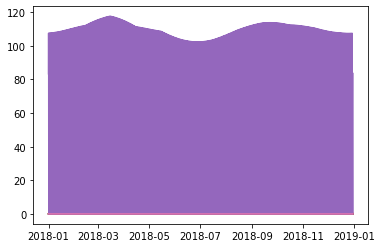

In [18]:
# import packages
import os
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np

# pvlib imports
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.iotools import read_tmy3
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

# Set Location
tz, altitude, name = 'Etc/GMT+10', 400, 'Mareeba/QLD'
location = Location(latitude=-17.0, longitude=145.4)

# load some module and inverter specifications
module_parameters = {
    'alpha_sc': 0.005,  # Isc temperature coefficient (A/C)
    'a_ref': 1.5,       # Modified diode ideality factor at reference conditions (unitless)
    'I_L_ref': 8,       # Light-generated current at reference conditions (A)
    'I_o_ref': 2.2e-9,  # Diode saturation current at reference conditions (A)
    'R_s': 0.5,         # Series resistance (ohms)
    'R_sh_ref': 20,     # Shunt resistance at reference conditions (ohms)
    'EgRef': 1.121,     # Bandgap energy at reference temperature (eV)
    'dEgdT': -0.0002677 # Temperature dependence of the bandgap energy (eV/C)
}

temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
inverter_parameters = {'pdc0': 5000, 'eta_inv_nom': 0.96}
system = PVSystem(
                    surface_tilt=20,
                    surface_azimuth=0,
                    inverter_parameters=inverter_parameters,
                    module_parameters=module_parameters,
                    albedo=0.2,
                    temperature_model_parameters=temperature_model_parameters
                    # modules_per_string=5,
                    # strings_per_inverter=5
                  )   

# Get Irradiance and weather
times = pd.date_range(start='2018-01-01', end='2018-12-31', freq='5min', tz=location.tz)
solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
apparent_zenith = solpos['apparent_zenith']
airmass = pvlib.atmosphere.get_relative_airmass(apparent_zenith)
pressure = pvlib.atmosphere.alt2pres(altitude)
airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
dni_extra = pvlib.irradiance.get_extra_radiation(times)
ineichen = clearsky.ineichen(apparent_zenith, airmass, linke_turbidity, altitude, dni_extra)

# Graph Irriadiance
# plt.figure();
# ax = ineichen.plot()
# ax.set_ylabel('Irradiance $W/m^2$');
# ax.set_title('Ineichen Clear Sky Model');
# ax.legend(loc=2);
# plt.show()

# build weather data
weather = pd.concat(
    [
        ineichen,
        pd.DataFrame(
            [[20.0, 5.0] for _ in range(ineichen.shape[0])],
            ineichen.index, ['temp_air', 'wind_speed']
        )
    ], axis=1)
print(weather.head(10))

# build model chain
mc = ModelChain(system, location, aoi_model="no_loss", spectral_model="no_loss")

print(mc)
# run model chain
mc.run_model(weather=weather)

register_matplotlib_converters()
plt.plot(mc.ac)
plt.show()